# Свёртка

Информация, которую можно было бы использовать в моделях, бывает очень разной. Например, в модель спокойно можно добавить фичи, созданные на основе фоток. Обычно это делается с помощью нейронок. Именно этим мы и займёмся. Однако для начала давайте немного поработаем с фотками. 

Для работы с фото мы будем использовать пакет `cv2`. Для его установки нужно прописать в консоли `pip install opencv-python`.  Для него написана довольно хорошая и понятная [документация.](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) 

In [1]:
#!pip install opencv-python

In [1]:
import numpy as np

import cv2

from matplotlib import pyplot as plt  # Графики 
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

## 1. Слово о тензорах и картинках

Подгрузим фотографию.

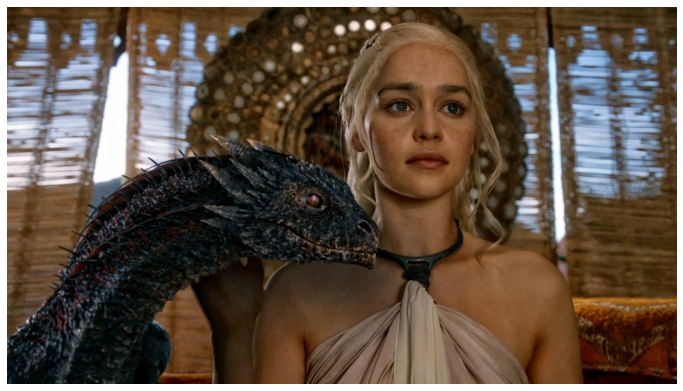

In [2]:
# Загружаем картинку
img = cv2.imread('Drakarys.jpg')  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Загружаем фотку и смотрим как она выглядит 
plt.figure(figsize = (12,8))
plt.imshow(img)
plt.axis("off");

Отлично, фото в наших руках. На самом деле каждая картинка это набор пикселей. Если мы попросим питон показать нам картинку, он покажет матрицу из чисел.  Каждому пикселю в этой матрице соответствует число. Это число сообщает нам о том насколько этот пиксель яркий. Яркость измеряется по шкале от $0$ до $255$.

In [3]:
# Видим, что у нас картинка размера 1080 на 1920 пикселей и описывается 3 матрицами (одна на каждый цвет)
img.shape 

(1080, 1920, 3)

Цветные картинки представляются в виде [тензора,](https://www.wikiwand.com/ru/%D0%A2%D0%B5%D0%BD%D0%B7%D0%BE%D1%80) то есть матрицы из матриц. Любой цвет можно получить, смешав в какой-то пропорции красный, зелёный и синий цвета. В связи с этим каждый пиксель обычно характеризуют тремя цифрами: (насколько пиксель красный, насколько пиксель зелёный, насколько пиксель синий). Такой формат хранения картинки называется [RGB-форматом.](https://www.wikiwand.com/ru/RGB)

In [5]:
img[:, :, 0] #Red

array([[62, 60, 59, ..., 58, 58, 58],
       [61, 60, 58, ..., 56, 56, 56],
       [60, 59, 58, ..., 52, 52, 52],
       ...,
       [ 2,  3,  5, ..., 16, 17, 16],
       [ 0,  3,  6, ..., 18, 20, 18],
       [ 0,  2,  6, ..., 20, 20, 20]], dtype=uint8)

In [6]:
img[:, :, 1] #Green

array([[37, 35, 34, ..., 44, 44, 44],
       [36, 35, 33, ..., 42, 42, 42],
       [35, 34, 33, ..., 37, 37, 37],
       ...,
       [20, 21, 23, ...,  2,  2,  2],
       [18, 21, 24, ...,  3,  2,  3],
       [17, 20, 24, ...,  2,  2,  2]], dtype=uint8)

In [7]:
img[:, :, 2] #Blue

array([[ 7,  5,  4, ..., 18, 18, 18],
       [ 6,  5,  3, ..., 16, 16, 16],
       [ 5,  4,  3, ..., 14, 14, 14],
       ...,
       [24, 25, 27, ...,  0,  0,  0],
       [22, 25, 28, ...,  0,  0,  0],
       [21, 24, 28, ...,  0,  0,  0]], dtype=uint8)

Все действия по редактированию картинки сводятся к математике. Чтобы осветлить картинку, нужно прибавить к каждому пикселю какое-то число. Для этого используют функцию `cv2.add`. В случае прибавления очень большого числа, она накопит яркость 255 и не пробьёт этот порог. Мы добвим 30 пунктов только к красной координате. Если захочется добавить 30 пунктов ко всем трём координатам, код придётся немного модернизировать. 

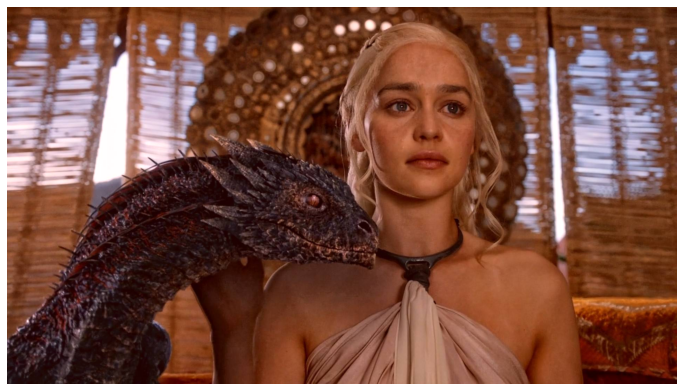

In [8]:
img_1 = cv2.add(img, 30)

plt.figure(figsize = (12,8))
plt.imshow(img_1)
plt.axis("off");

Умножение каждого пикселя на какое-то число увеличит контраст. Также проделаем этот фокус только с красной координатой. 

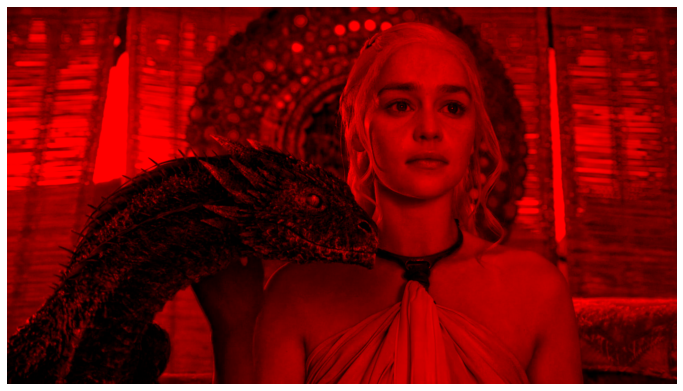

In [9]:
img_1 = cv2.multiply(img, 1.3) # повышаем контраст

plt.figure(figsize = (12,8))
plt.imshow(img_1)
plt.axis("off");

Можно посмотреть на то как распределены на картинке пиксели различной яркости.

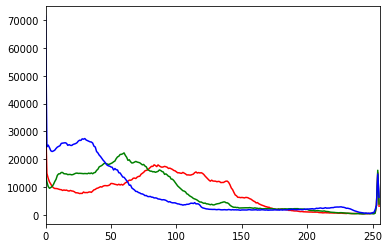

In [10]:
color = ('r','g','b')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

## 2. Эквализация гистограммы

Изобразим гистограмму картинки и эмпирическую функцию распределения яркости пикселя.

Наши пиксели, на представленной ниже картинке сосредочены по своей яркости на определённом промежутке. Из-за этого мы не можем чётко выделить объекты на картинке. Если мы растянем пиксели по яркости в разные углы интервала, объекты начнут выделяться более чётко. В этом состоит смысл эквилизации. В ходе этого растягивания эмпирическая функция распределеия станет прямой. 

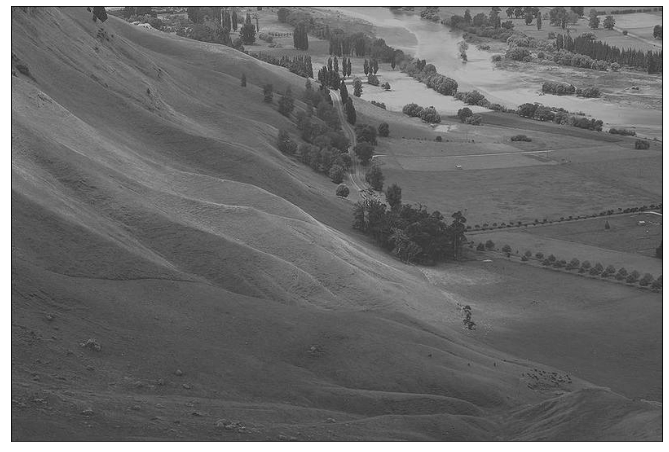

In [11]:
img = cv2.imread('forest.jpg',0)

plt.figure(figsize = (12,8))
plt.imshow(img,cmap='gray')
plt.xticks([]), plt.yticks([]);

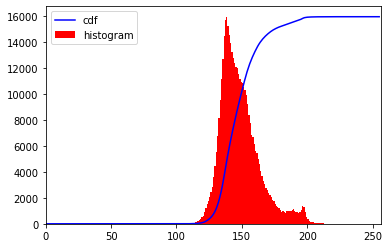

In [12]:
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left');

Проделаем эквализацию. 

In [13]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())/(cdf_m.max()-cdf_m.min()) * 255
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[img]

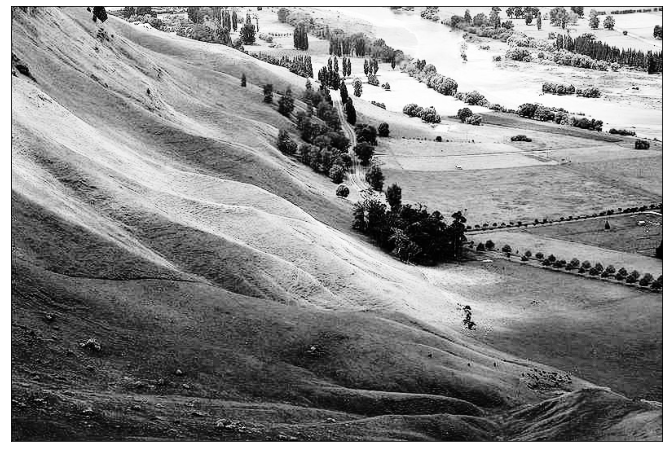

In [14]:
plt.figure(figsize = (12,8))
plt.imshow(img2,cmap='gray')
plt.xticks([]), plt.yticks([]);

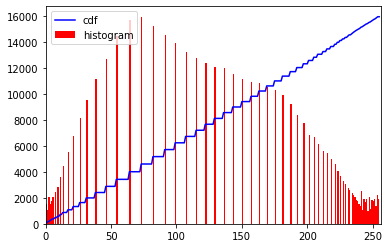

In [15]:
hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left');

Контраст на изображении стал виден более чётко. Гистограмма растянулась по яркости на весь диапозон. Внутри пакета есть более удобная для эквализации функция.

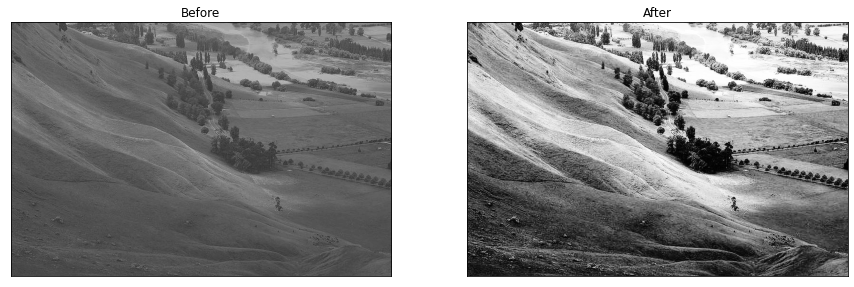

In [16]:
plt.figure(figsize = (15,15))

img2 = cv2.equalizeHist(img) # эквилизация гистограммы

plt.subplot(121),plt.imshow(img,cmap='gray'),plt.title('Before')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2,cmap='gray'),plt.title('After')
plt.xticks([]), plt.yticks([]);

## 3. Свёртка

Свёртка это операция, которая превращает набор одних пикселей в другие. Обычно она осуществляется с помощью ядра свёртки, матрицы произвольного размера (обычно 3х3). Центральный элемент такой матрицы называется якорем свёртки. Он применяется к центральному пикселю. 

Работает свёртка очень просто. При вычислении нового значения выбранного пикселя изображения, ядро свёртки прикладывается своим центром к этому пикселю. Далее, вычисляется сумма произведений значений пикселей изображения на значения, накрывшего данный пиксель элемента ядра. Полученная сумма и является новым значением выбранного пикселя.


<center>
<img src="convolution_schematic.gif">
</center>

Используя матрицы с разными коэффициентами можно получать раные эффекты. 

Попробуем ухудшить качество изображения. В этом нам поможет следующее ядро размера 3 на 3.

$$ K = \frac{1}{9} \cdot \begin{pmatrix}
1 & 1 & 1  \\
1 & 1 & 1  \\         
1 & 1 & 1 
\end{pmatrix} $$

Оно берёт пиксель в каждом квадрате размера 3 на 3 и заменяет его на арифмитическое среднее всех пикселей. Таким образом размерность картинки и её качество падают.

In [27]:
img = cv2.imread('Drakarys.jpg')  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

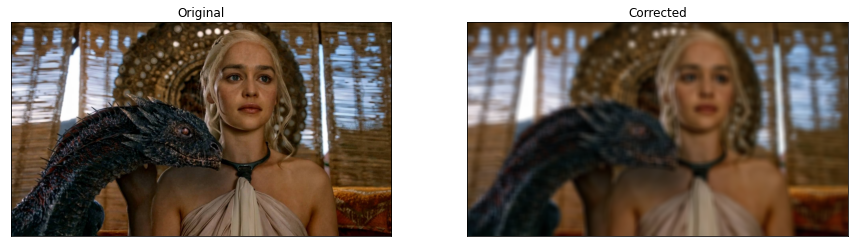

In [28]:
plt.figure(figsize=(15,12))

kernel = np.ones((30,30),np.float32)/900  # Создали в нумпай матрицу из 1/900 размера 30 на 30
dst = cv2.filter2D(img,-1,kernel)         # применили матрицу к нашей картинке 

plt.subplot(121),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([]);

Попробуем применить другие ядра. Например, ядро для сглаживания.

$$ \begin{pmatrix}
0.1 & 0.1 & 0.1  \\
0.1 & 0.1 & 0.1 \\         
0.1 & 0.1 & 0.1 
\end{pmatrix} $$

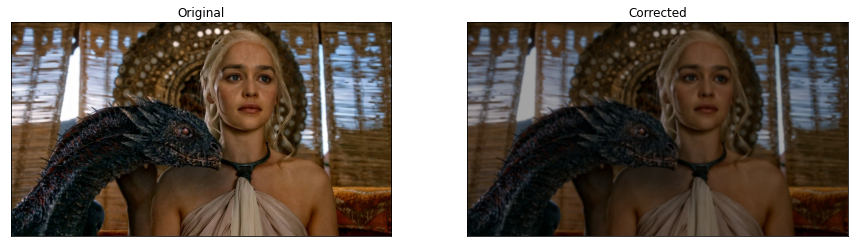

In [29]:
plt.figure(figsize=(15,12))

kernel = 0.01*np.ones((8,8),np.float32)
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([]);

Ядро для увеличения чёткости. Обратите внимание на большое значение якоря.

$$ \begin{pmatrix}
-0.1 & -0.1 & -0.1  \\
-0.1 & 2 & -0.1 \\         
-0.1 & -0.1 & -0.1 
\end{pmatrix} $$

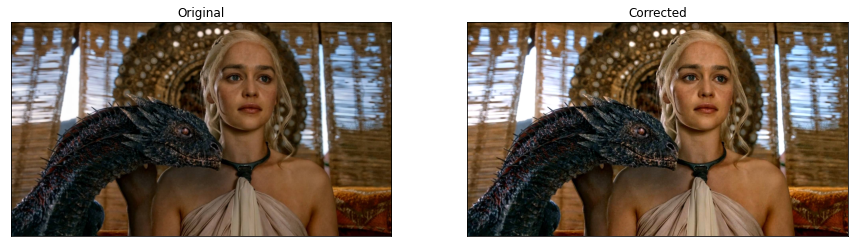

In [30]:
plt.figure(figsize=(15,12))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1] = 2
dst = cv2.filter2D(img,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([]);

Забавно, что при повторном применении фильтра для увеличения чёткости, картинка покрывается шумом.

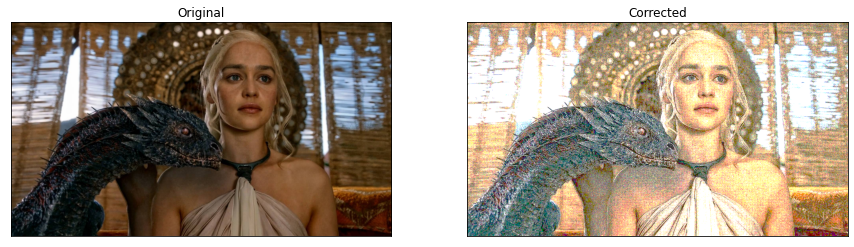

In [35]:
plt.figure(figsize=(15,12))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1] = 2
dst = cv2.filter2D(img,-1,kernel)
# Повторяем повторно фильтр 20 раз 
for i in range(20):
    dst = cv2.filter2D(dst,-1,kernel)

plt.subplot(121),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title('Corrected')
plt.xticks([]), plt.yticks([]);

Гауссовский фильтр хорошо удаляет шум.  Чуствуете иронию? Нормальное распределение пригождается фотошоперам в жизни на ежедневной основе! Правда они даже не знают об этом...

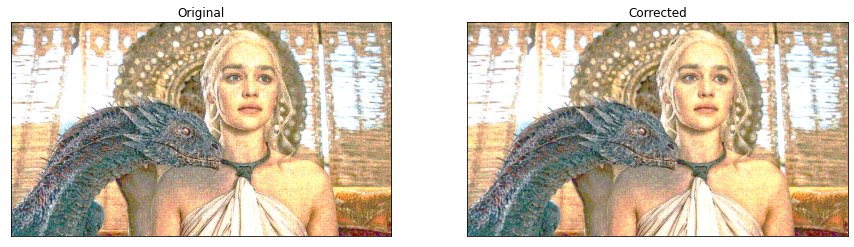

In [36]:
plt.figure(figsize=(15,12))

blur_0 = cv2.GaussianBlur(dst,(5,5),0)
plt.subplot(121),plt.imshow(dst),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur_0),plt.title('Corrected')
plt.xticks([]), plt.yticks([]);

Ядра бывают очень разными. Например, вы можете попробовать использовать следующие: 

* Ядро для увеличения яркости. 

$$ \begin{pmatrix}
-0.1 & 0.2 & -0.1  \\
0.2 & 3 & 0.2 \\         
-0.1 & 0.2 & -0.1 
\end{pmatrix} $$

* Ядро для затемнения. 

$$ \begin{pmatrix}
-0.1 & 0.1 & -0.1  \\
 0.1 & 0.5 & 0.1 \\         
-0.1 & 0.1 & -0.1 
\end{pmatrix} $$

* Ядро, которое ничего не делает 

$$ \begin{pmatrix}
0 & 0 & 0  \\
0 & 1 & 0 \\         
0 & 0 & 0 
\end{pmatrix} $$

* Ядро, которое сдвигает картинку

$$ \begin{pmatrix}
1 & 0 & 100  \\
0 & 1 & 50     
\end{pmatrix} $$


* Эрозия и наращивание. Выбираем пиксель с максимальной или минимальной интенсивностью из окрестности.  Наращиваение приводит к увеличению ярких объектов, а эрозия к увеличению тёмных. Наращивание может быть использовано для увеличения бликов ярких изображений. Обычно эрозия имеет округлую форму и выглядит, например, так:

$$ \begin{pmatrix}
0 & 0 & 1 & 0 & 0  \\
0 & 1 & 1 & 1 & 0  \\         
1 & 1 & 1 & 1 & 1  \\
0 & 1 & 1 & 1 & 0  \\        
0 & 0 & 1 & 0 & 0
\end{pmatrix} $$


Абсолютно любая матрица задаёт какое-то преобразование линейного пространства. В данном случае нашей фотографии. При хорошем знании линала, вы можете придумать самые безумные ядра. Попробуйте! 

In [37]:
# Ваш код для игры в фильтры 

## 3. Углубляемся в свёртку

Попробуйте угадать, что делают следующие два фильтра. 

$$ \begin{pmatrix}
-1 & -1 & -1  \\
0 & 0 & 0 \\         
1 & 1 & 1 
\end{pmatrix}  $$

$$ \begin{pmatrix}
-1 & 0 & 1  \\
-1 & 0 & 1 \\         
-1 & 0 & 1 
\end{pmatrix} $$


Ответ: поиск горизонтальных и вериткальных границ

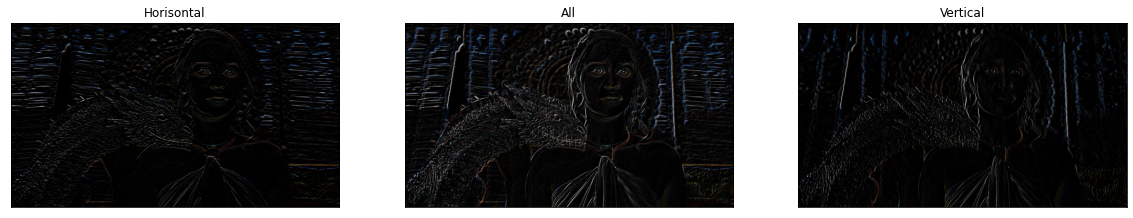

In [38]:
plt.figure(figsize=(20,20))

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(img,-1,kernel1)
dst2 = cv2.filter2D(img,-1,kernel2)
gr1 = cv2.add(dst1,dst2)

plt.subplot(131),plt.imshow(dst1),plt.title('Horisontal')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(gr1),plt.title('All')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst2),plt.title('Vertical')
plt.xticks([]), plt.yticks([]);

Если сначала обработать картинку ядром для повышения чёткости, а после применить фильр для поиска границ, они детектируются более чётко. 

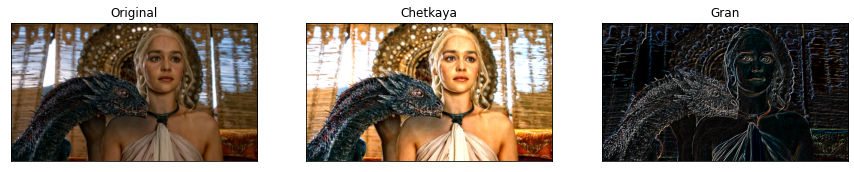

In [39]:
plt.figure(figsize=(15,15))

kernel = -0.1*np.ones((3,3),np.float32)
kernel[1,1]=2
dst = cv2.filter2D(img,-1,kernel)
# Забавно, что при повторном применении этого Ядра картинка покрывается шумом! 
for i in range(3):
    dst = cv2.filter2D(dst,-1,kernel)
    
# Можно почистить картинку от шума 
dst = cv2.GaussianBlur(dst,(5,5),0)

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(dst,-1,kernel1)
dst2 = cv2.filter2D(dst,-1,kernel2)
gr2 = cv2.add(dst1,dst2)

plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(dst),plt.title('Chetkaya')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(gr2),plt.title('Gran')
plt.xticks([]), plt.yticks([]);

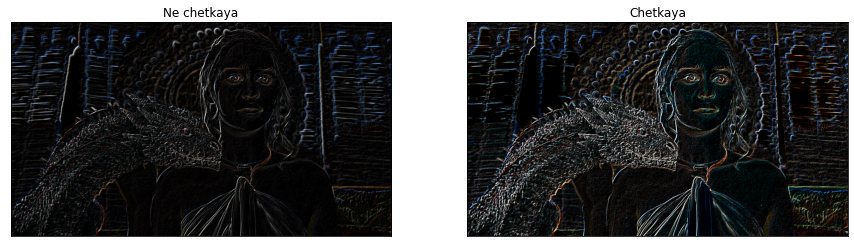

In [40]:
plt.figure(figsize=(15,15))

plt.subplot(121),plt.imshow(gr1),plt.title('Ne chetkaya')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gr2),plt.title('Chetkaya')
plt.xticks([]), plt.yticks([]);

Вроде бы граница получилась более чёткой. Внутри пакета есть своя функция для выделения границы. Он работает более агрессивно нежели наше ядро.

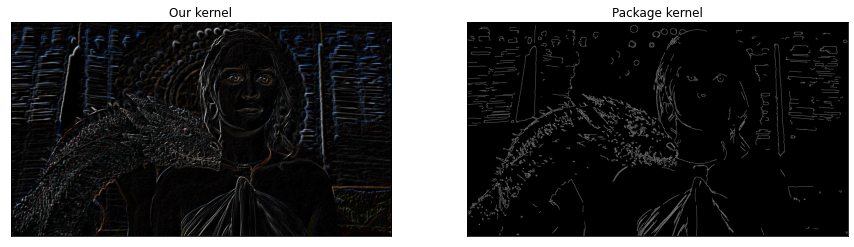

In [41]:
plt.figure(figsize=(15,15))

kernel1 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]],np.float32)
kernel2 = kernel1.T

dst1 = cv2.filter2D(img,-1,kernel1)
dst2 = cv2.filter2D(img,-1,kernel2)
my_gr = cv2.add(dst1,dst2)

# Пакетная функция:
its_gr = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(my_gr),plt.title('Our kernel')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(its_gr,cmap='gray'),plt.title('Package kernel')
plt.xticks([]), plt.yticks([]);

Можно побаловаться с более крутыми градиентами, в том числе диагональными.

$$ \begin{pmatrix}
0 & 1 & 2  \\
-1 & 0 & 1 \\         
-2 & -1 & 0 
\end{pmatrix} $$

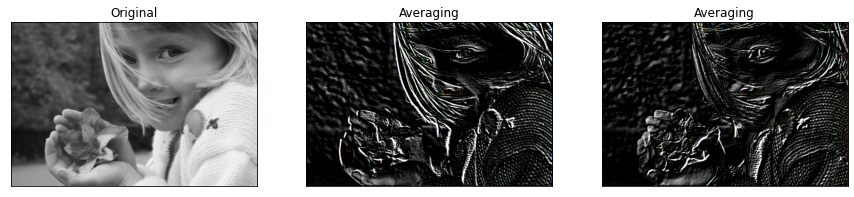

In [43]:
plt.figure(figsize=(15,15))

img = cv2.imread('girl.png',0)
img = cv2.cvtColor(img,cv2.COLOR_BAYER_BG2BGR) # Сделаем картинку серой

kernel1 = 3*np.array([[0,1,2],[-1,0,1],[-2,-1,0]],np.float32)
dst1 = cv2.filter2D(img,-1,kernel1)

kernel2 = 3*np.array([[2,1,0],[1,0,-1],[0,-1,-2]],np.float32) #транпонированный фильтр
dst2 = cv2.filter2D(img,-1,kernel2)

plt.subplot(131),plt.imshow(img,),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(dst1),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(dst2),plt.title('Averaging')
plt.xticks([]), plt.yticks([]);

Как вы уже догадались, можно придумать фильры не только для поиска границ, но и для поиска других различных закономерностей, которые есть на картинке. 

Представим себе на секунду славный дивный мир, в котором бывают картинки только двух типов: с прямыми слэшами и с обратными (/ \). При этом, эти слэши могут быть нарисованы на картинке где угодно. Пусть у нас есть две картинки. На одной из них слэш нарисован внизу справа, на второй сверху слева. Пройдёмся по нашим картинкам специальным ядром, которое ищет обратные слэши. После свёртки, мы получим на выходе две уменьшившиеся в размерах картинки, в каждой из которых будет фигурировать цифра два, как раз отвечающая за найденный обратный слэш.

<img align="center" src="photo_1.png" height="500" width="500"> 

Если точно такое же ядро натравить на картинку без обратного слэша, оно не выдаст нам на выход никакой двойки. 

<img align="center" src="photo_2.png" height="600" width="600"> 

Получаем простейший классификатор картинок с слэшами. 

1. Проходимся по картинке ядром. 
2. Находим в итоговой матрице максимальный элемент.
3. Если это двойка, на картинке изображён слэш. Если это единица, на картинке обратный слэш.

Обратите внимание, что работа этого классификатора не зависит от того, где именно на картинке находится слэш. Именно так свёрточные нейронные сети и работают с картинками. Конечно же, в реальности закономерности на картинках на порядок сложнее. При этом, мы даже не знаем какими именно могут быть эти закономерности. Для того, чтобы их искать, в нейронную сетку добавляются ядра с неспецифицированными параметрами.

$$ \begin{pmatrix}
w_1 & w_2 & w_3  \\
w_4 & w_5 & w_6 \\         
w_7 & w_8 & w_9 
\end{pmatrix} $$

Слои, на которых находятся эти ядра называются свёрточными. Параметры подбираются в ходе обучения нейронной сети по реальным данным и отражают в себе какие-то закономерности, найденные во время обучения на картинках. Представим, что наша нейронная сеть должна уметь распознавать лица. Добавим в неё несколько свёрточных слоёв. 

Первый слой будет находить простейшие элементы, такие как слэши, прямые чёрточки и извилистые чёрточки. Второй слой будет конструировать из элементов, найденных на первом слое, ещё более сложные штуки. В данном случае окружности и крестики. Третий слой будет конструировать из объектов, найденных на втором слое ещё более сложные объекты. Таким образом, мы, слой за слоем, будем собирать всё более и более сложные объекты до тех пор, пока не дойдём до котика. 

<img align="center" src="photo_3.png" height="600" width="600"> 

Обычно закономерности, которые находит свёрточная сеть сложно интерпретируемы. Тем не менее, мы можем забрать те закономерности, которые нашла нейросетка и использовать их в качестве регрессоров в какой-то более интерпретируемой модели.